In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# %config InlineBackend.figure_format = 'svg'
config = {'font.family': 'Times New Roman',
          'font.size': 15,
          'xtick.direction': 'in',
          'ytick.direction': 'in',
          'mathtext.fontset': 'stix',
         }
plt.rcParams.update(config)

scenario = "B"

results = np.load(f"./output/{scenario}/results.npy").reshape(61, 30, 100, 400) # 时刻 种类
n = np.load(f"./output/{scenario}/results_porosity.npy").reshape(61, 100, 400)
K = np.load(f"./output/{scenario}/results_K.npy").reshape(61, 100, 400)
K_log = np.log(K)

print(results.shape)
print(n.shape)
print(K.shape)
# print(heads.shape)

# ['0 K' '1 Na' '2 Ca' '3 Mg' '4 Li' '5 Cl' '6 S(6)' '7 C(4)' '8 Halite'
#  '9 Carnallite' '10 Polyhalite' '11 Sylvite' '12 Gypsum' '13 Calcite' '14 Dolomite'
#  '15 d_Halite' '16 d_Carnallite' '17 d_Polyhalite' '18 d_Sylvite' '19 d_Gypsum' '20 d_Calcite' '21 d_Dolomite'
#  '22 density(kg/m3)'
#  '23 SI_Halite' '24 SI_Carnallite' '25 SI_Polyhalite' '26 SI_Sylvite' '27 SI_Gypsum' '28 SI_Calcite' '29 SI_Dolomite']

(61, 30, 100, 400)
(61, 100, 400)
(61, 100, 400)


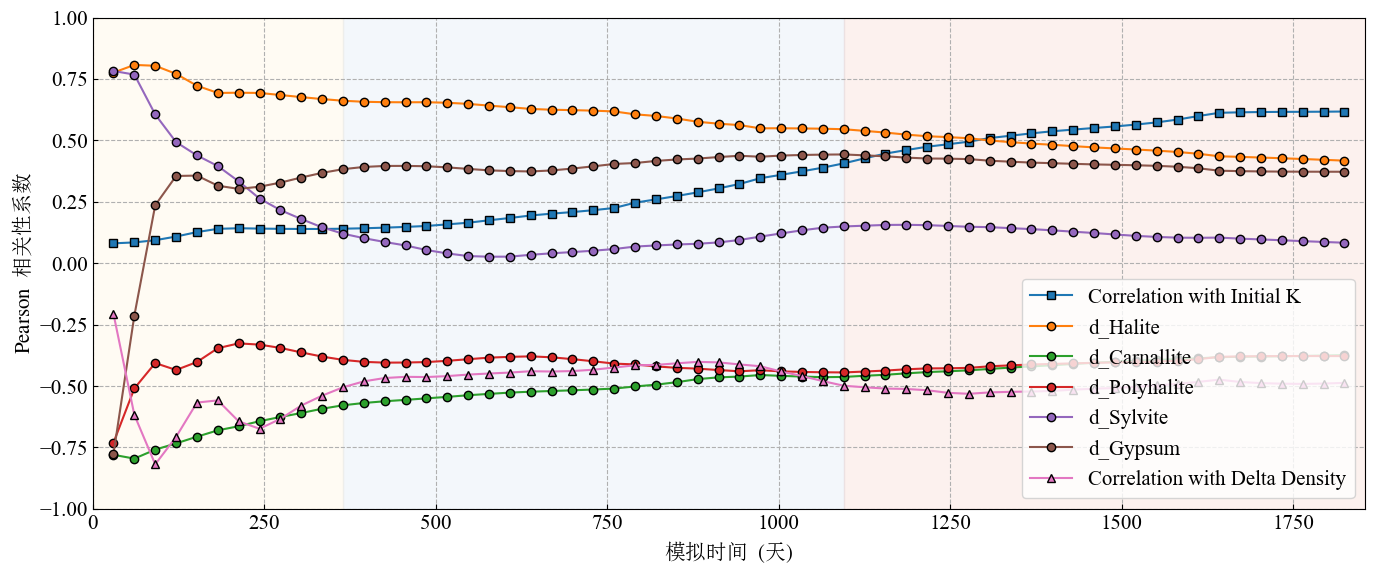

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

n_times, ny, nx = K.shape
time_steps_days = np.linspace(0, 1825, n_times)
time_steps_analyze = time_steps_days[1:]

d_halite_idx = 15
d_carnallite_idx = 16
d_polyhalite_idx = 17
d_sylvite_idx = 18
d_gypsum_idx = 19
density_idx = 22

mineral_indices = {
    'd_Halite': d_halite_idx,
    'd_Carnallite': d_carnallite_idx,
    'd_Polyhalite': d_polyhalite_idx,
    'd_Sylvite': d_sylvite_idx,
    'd_Gypsum': d_gypsum_idx,
}
mineral_names = list(mineral_indices.keys())

K_initial = K[0, :, :]
delta_K = K[1:, :, :] - K_initial # Shape: (60, 100, 400)

d_minerals_step = results[1:, list(mineral_indices.values()), :, :] # Shape: (60, num_minerals, 100, 400)
cumulative_d_minerals = np.cumsum(d_minerals_step, axis=0) # Shape: (60, num_minerals, 100, 400)

density_initial = results[0, density_idx, :, :]
delta_density = results[1:, density_idx, :, :] - density_initial # Shape: (60, 100, 400)

num_analyze_times = n_times - 1
correlation_results = {
    'K_initial': [],
    'density': [],
}
for mineral_name in mineral_names:
    correlation_results[mineral_name] = []

for t in range(num_analyze_times):
    current_delta_K_flat = delta_K[t, :, :].flatten()

    K_initial_flat = K_initial.flatten()
    corr_k_init, _ = pearsonr(current_delta_K_flat, K_initial_flat)
    correlation_results['K_initial'].append(corr_k_init)

    for i, mineral_name in enumerate(mineral_names):
        current_cum_d_mineral_flat = cumulative_d_minerals[t, i, :, :].flatten()
        corr_mineral, _ = pearsonr(current_delta_K_flat, current_cum_d_mineral_flat)
        correlation_results[mineral_name].append(corr_mineral)

    current_delta_density_flat = delta_density[t, :, :].flatten()
    corr_density, _ = pearsonr(current_delta_K_flat, current_delta_density_flat)
    correlation_results['density'].append(corr_density)

plt.figure(figsize=(14, 6))
plt.plot(time_steps_analyze, correlation_results['K_initial'], label='Correlation with Initial K', marker='s', markeredgecolor='black', )
for mineral_name in mineral_names:
    plt.plot(time_steps_analyze, correlation_results[mineral_name], label=fr'{mineral_name}', marker='o', linestyle='-', markeredgecolor='black', )

plt.plot(time_steps_analyze, correlation_results['density'], label='Correlation with Delta Density', marker='^', linestyle='-', markeredgecolor='black', )

plt.xlabel(r'模拟时间 $\mathrm{(}$天$\mathrm{)}$', fontdict={'family': 'SimSun'})
plt.ylabel(r'$\mathrm{Pearson}$ 相关性系数', fontdict={'family': 'SimSun'})
plt.legend()
plt.grid(visible=True, which='major', axis='both', linestyle='--')
plt.ylim(-1.0, 1.0)
plt.xlim(0, 1855)

plt.axvspan(0, 365, color='#FFDD8E', alpha=0.1, label=r'第 $1$ 年 $(t < 36)$')
plt.axvspan(365, 1095, color='#8FB4DC', alpha=0.1, label=r'第 $2$ 年 $(36 \leq t < 73)$')
plt.axvspan(1095, 1855, color='#EB7E60', alpha=0.1, label=r'第 $3$ 年 $(t \geq 73)$')

plt.tight_layout()
plt.show()